In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def show_image(cv_image, title="Image Preview", size=(12, 10)):
    """Convert BGR image to RGB and display it in Notebook"""
    rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=size)
    plt.imshow(rgb)
    plt.axis('off')
    plt.title(title)
    plt.show()


In [14]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 21, 10
    )
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilated = cv2.dilate(thresh, kernel_dilate, iterations=2)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8)
    h, w = gray.shape
    char_boxes = []
    for i in range(1, num_labels):
        x, y, bw, bh, area = stats[i]
        if 70 < area < 0.08 * h * w and 5 < bw < w and 5 < bh < h:
            char_boxes.append((x, y, bw, bh))

    char_boxes_sorted = sorted(char_boxes, key=lambda b: (b[0] // 18, b[1]))
    
    #Display initial annotation results
    annotated = image.copy()
    for i, (x, y, bw, bh) in enumerate(char_boxes_sorted):
        cv2.rectangle(annotated, (x, y), (x + bw, y + bh), (0, 255, 0), 1)
        cv2.putText(annotated, str(i + 1), (x, y - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)

    show_image(annotated, "Initial character box recognition+numbering")
    return image, char_boxes_sorted


In [15]:
#Save the selected number content
def save_selected_characters(image, char_boxes_sorted, selected_ids, output_dir="output_chars"):
    """
    Save selected character images by their indices to a folder.

    Parameters:
        image (ndarray): The original image.
        char_boxes_sorted (list): List of (x, y, w, h) for each character box.
        selected_ids (list of int): Indices of characters to save (1-based).
        output_dir (str): Directory to save the cropped character images.
    """
    # Create folder if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    count = 0
    for idx in selected_ids:
        if 1 <= idx <= len(char_boxes_sorted):
            x, y, w, h = char_boxes_sorted[idx - 1]
            cropped = image[y:y+h, x:x+w]
            save_path = os.path.join(output_dir, f"char_{idx}.png")
            cv2.imwrite(save_path, cropped)
            count += 1

    print(f"✅ Saved {count} characters to folder: {output_dir}")


In [16]:
#Character Splicing # Character Splicing
def stitch_characters(image, char_boxes_sorted, to_stitch, direction="horizontal"):
    char_images = []
    max_height = max([image[y:y+h, x:x+w].shape[0] for x, y, w, h in [char_boxes_sorted[i-1] for i in to_stitch]])
    for i in to_stitch:
        if 1 <= i <= len(char_boxes_sorted):
            x, y, w, h = char_boxes_sorted[i - 1]
            char = image[y:y+h, x:x+w]
            canvas = np.ones((max_height, w, 3), dtype=np.uint8) * 255
            canvas[:h, :w] = char
            char_images.append(canvas)
    if char_images:
        stitched = cv2.hconcat(char_images) if direction == "horizontal" else cv2.vconcat(char_images)
        show_image(stitched, "Function 1: Character stitching result")
    else:
        print(" There are no characters that can be pieced together")


In [17]:
#Delete characters+boxes+numbers
def delete_characters_full(image, char_boxes_sorted, to_delete_full):
    img = image.copy()
    for i in to_delete_full:
        if 1 <= i <= len(char_boxes_sorted):
            x, y, w, h = char_boxes_sorted[i - 1]
            cv2.rectangle(img, (x, y - 15), (x + w, y + h), (255, 255, 255), -1)
    show_image(img, "Function 2A: Delete Character Region (including Number)")


In [18]:
##Only remove borders and numbers
def delete_labels_only(image, char_boxes_sorted, to_delete_label_only):
    img = image.copy()
    for i in range(len(char_boxes_sorted)):
        x, y, w, h = char_boxes_sorted[i]
        idx = i + 1
        if idx not in to_delete_label_only:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
            cv2.putText(img, str(idx), (x, y - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    show_image(img, "Function 2B: Keep only the selected box and number")


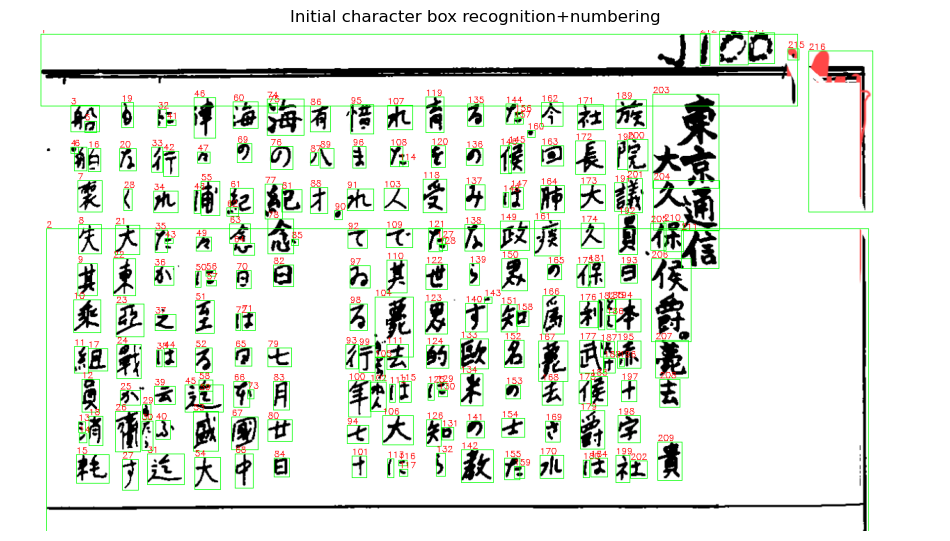

In [19]:
#Read image and character box information
image_path = "page_1_part1_final.png"
image, char_boxes_sorted = preprocess_image(image_path)


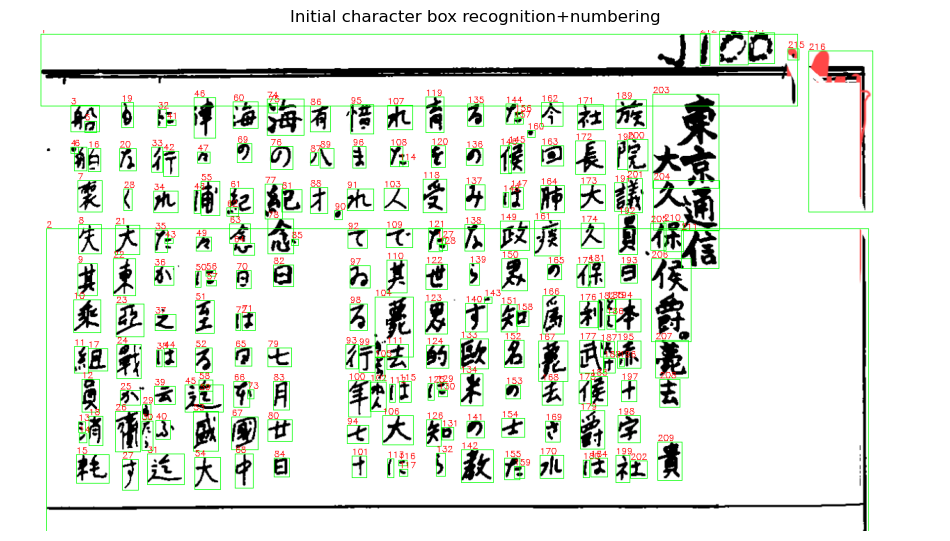

✅ Saved 1 characters to folder: my_chars


In [20]:
image, char_boxes = preprocess_image(image_path)
selected_ids = [203]  # or use input() to get from user
save_selected_characters(image, char_boxes, selected_ids, output_dir="my_chars")


In [ ]:
#Example: Splicing the 2nd, 3rd, and 4th characters together
stitch_characters(image, char_boxes_sorted, to_stitch=[2, 3, 4], direction="horizontal")

In [ ]:
#Example: Delete the 1st, 5th, and 9th characters (area+box+number)
delete_characters_full(image, char_boxes_sorted, to_delete_full=[1, 5, 9])


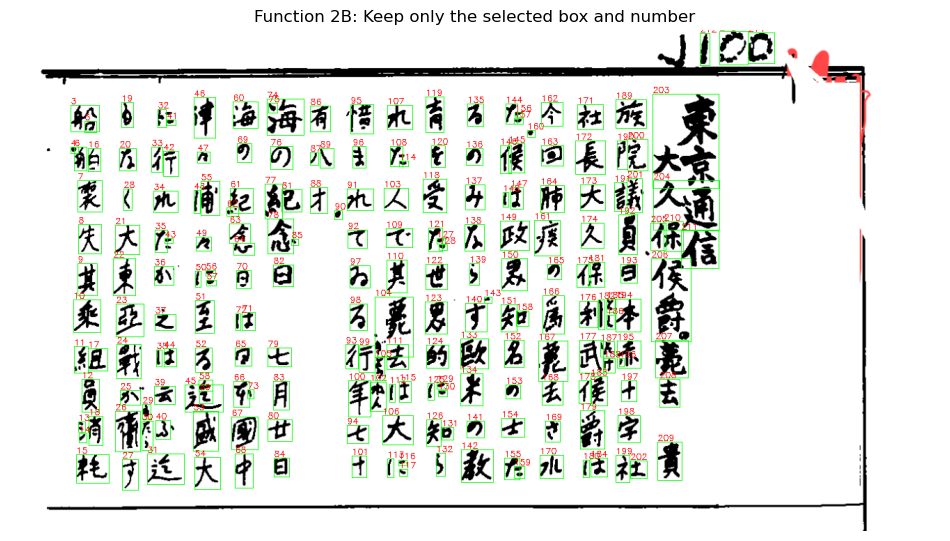

In [12]:
#Example: Delete only the borders and numbers of 
delete_labels_only(image, char_boxes_sorted, to_delete_label_only=[216,215,1,2])
